In [1]:
# Only uncomment if you are running notebook using Docker image
import os; os.environ['PROJ_LIB'] = '/opt/conda/share/proj'

In [2]:
import pandas as pd
from scripts import system_codes
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Load BOG buoys from file
buoys_df = pd.read_csv("data/buoys.tsv", delimiter='\t')
int_df = buoys_df.copy()

# Segment the buoy messages into deployments based on their “Entered Water” and “Left Water'' flags
int_df['system_status'] = int_df['system_status'].fillna('Unknown')
int_df['system_status_int'] = int_df['system_status'].apply(lambda x : int(x) if x != 'Unknown' else 'Unknown')
int_df['system_status_cat'] = int_df['system_status_int'].apply(lambda x : system_codes.parse_system_flags(x) if x!= 'Unknown' else 'Unknown')
int_df['system_status_interpret'] = int_df['system_status_cat'].apply(lambda x:system_codes.human_readable_reason(x))

# Subset to desired columns
cols_to_keep = [
    'sensor_id',
    'datetime',
    'latitude',
    'longitude',
    'system_status_interpret'
]
buoys_interval = int_df[cols_to_keep]

# Change datetime type
buoys_interval['datetime'] = pd.to_datetime(buoys_interval['datetime'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

# Sort and reset index
buoys_interval = buoys_interval.sort_values(by=['sensor_id', 'datetime']).reset_index(drop = True)
buoys_interval #31398 rows

# Calculate interval
buoys_interval['interval'] = buoys_interval.groupby('sensor_id')['datetime'].diff() 

# Readings with an "Entered Water" status should always have a value of NaT
buoys_interval.loc[buoys_interval['system_status_interpret'] == "Entered Water", 'interval'] = "" 

/tmp/ipykernel_923/3369110027.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buoys_interval['datetime'] = pd.to_datetime(buoys_interval['datetime'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')


In [6]:
buoys_interval[55:59]

,sensor_id,datetime,latitude,longitude,system_status_interpret,interval
55,103,2022-04-26 06:36:06,47.583550,-62.456200,Entered Water,NaT
56,103,2022-04-26 08:41:36,47.583420,-62.456430,Scheduled,0 days 02:05:30
57,103,2022-04-27 08:41:36,47.583420,-62.455822,Scheduled,1 days 00:00:00
58,103,2022-04-27 14:30:16,47.583786,-62.457035,Left Water,0 days 05:48:40


In [37]:
# Convert interval to minutes and round down to the nearest minute
buoys_interval['interval_min'] = buoys_interval['interval'].dt.total_seconds().div(60).apply(np.floor).astype('Int64')


In [38]:
buoys_interval['interval_min'].describe()

count     28555.000000
mean        585.438102
std        5365.398530
min           0.000000
25%          60.000000
50%         719.000000
75%         720.000000
max      309399.000000
Name: interval_min, dtype: float64

In [39]:
# Display outliers with intervals more than 2 days (i.e., 2880 mins)
buoys_interval.loc[buoys_interval['interval_min'] > 2880]

,sensor_id,datetime,latitude,longitude,system_status_interpret,interval,interval_min
6,103,2021-10-26 23:14:31,37.471134,-121.940420,Left Water,208 days 05:26:50,299846
547,104,2021-10-26 23:14:50,37.471394,-121.939780,Left Water,208 days 00:34:46,299554
749,105,2021-10-26 23:15:09,37.471120,-121.940370,Left Water,208 days 06:50:03,299930
812,105,2022-05-14 10:24:07,47.341560,-62.587036,Resurfaced,2 days 02:20:31,3020
925,106,2021-10-27 18:00:55,37.471260,-121.940240,Scheduled,209 days 00:34:26,300994
949,107,2022-02-02 22:30:04,37.471190,-121.940230,Left Water,5 days 04:36:54,7476
969,107,2022-03-17 21:25:06,37.471280,-121.940270,Left Water,20 days 01:51:56,28911
1139,108,2021-10-27 18:15:36,37.471264,-121.940180,Scheduled,209 days 00:10:30,300970
1344,109,2021-10-27 18:26:58,37.471260,-121.940280,Scheduled,209 days 00:56:54,301016
1534,110,2021-10-27 18:13:36,37.471245,-121.940160,Scheduled,209 days 00:43:32,301003


Text(0, 0.5, 'Frequency')

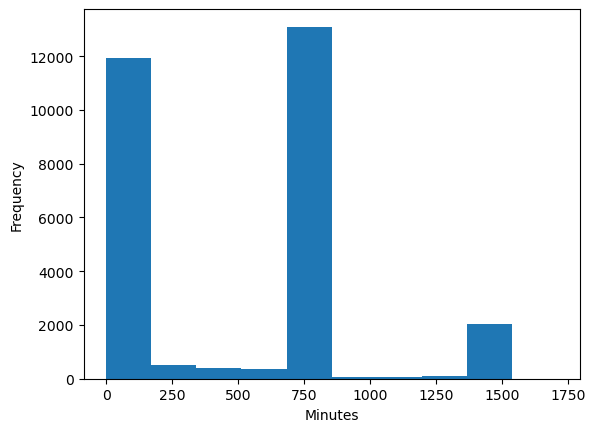

In [40]:
# Only plot non-nan values 
buoys_interval_nonan = buoys_interval.loc[buoys_interval['interval_min'] != ""] 

# Only plot less than 2880 mins 
buoys_interval_normal = buoys_interval_nonan.loc[buoys_interval['interval_min'] < 2880] 

plt.hist(buoys_interval_normal['interval_min'])
plt.xlabel("Minutes")
plt.ylabel("Frequency")

# plt.xticks(np.arange(0, 1750, 50))
# plt.xticks(rotation=30)


Text(0, 0.5, 'Frequency')

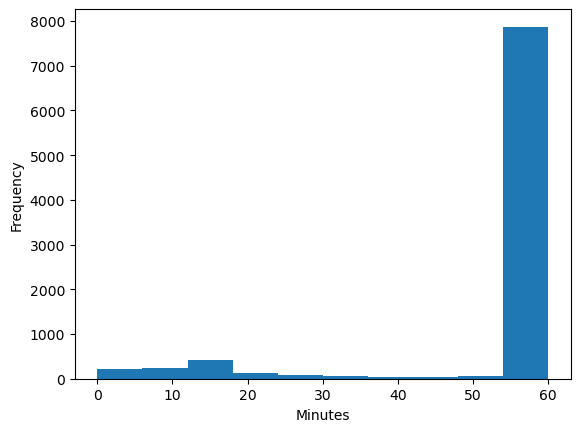

In [44]:
# Only plot less than 60 mins 
buoys_interval_normal = buoys_interval_nonan.loc[buoys_interval['interval_min'] <= 60] 

# Dropping messages without lat/lon
buoys_interval_normal = buoys_interval_normal.loc[buoys_interval_normal['latitude'].notnull()]

plt.hist(buoys_interval_normal['interval_min'])
plt.xlabel("Minutes")
plt.ylabel("Frequency")

In [46]:
# DF with lat and lon 
buoys_interval_with_loc = buoys_interval_normal.loc[buoys_interval_normal['latitude'].notnull()]

# Top 10 shortest intervals
buoys_interval_with_loc.sort_values(by=['interval_min']).head(10)

,sensor_id,datetime,latitude,longitude,system_status_interpret,interval,interval_min
537,104,2021-03-26 20:30:04,37.471252,-121.940400,Left Water,0 days 00:00:36,0
30138,678,2022-08-17 04:30:04,39.903248,-69.046425,Left Water,0 days 00:01:58,1
20232,545,2022-03-04 21:01:25,37.471207,-121.940370,Left Water,0 days 00:01:39,1
4587,129,2021-03-30 19:10:04,37.471134,-121.939870,Left Water,0 days 00:01:45,1
5359,460,2022-03-04 21:00:04,37.471138,-121.940190,Left Water,0 days 00:01:28,1
23722,556,2022-03-07 18:24:12,37.471104,-121.939920,Left Water,0 days 00:02:42,2
1337,108,2022-06-22 09:13:43,48.034890,-62.217007,Left Water,0 days 00:02:45,2
23241,553,2022-03-04 16:30:04,37.471226,-121.940315,Left Water,0 days 00:02:48,2
4190,125,2021-03-26 21:00:04,37.471275,-121.940180,Left Water,0 days 00:02:08,2
1687,111,2021-03-26 00:20:04,37.471830,-121.939770,Left Water,0 days 00:02:42,2
